In [1]:
import torch as th
import torch
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt
import math
from functools import reduce
from itertools import product

In [2]:
def getCropCoords(shp, cropsz, margin):
    croplims=[]
    if not hasattr(margin,'__len__'): margin=[margin]*len(shp)
    for sz,cs,m in zip(shp,cropsz,margin):
        # Ensure margin doesn't create negative start index
        # Clamp end index to shape size for non-margined crops (margin=0)
        # Allow margined crops to potentially exceed shape size boundaries for graph cropping
        if m == 0:
            croplims.append([slice(a, min(a+cs,sz)) for a in range(0,sz,cs)])
        else:
            croplims.append([slice(max(0, a-m), min(a+cs+m, sz+2*m)) for a in range(0,sz,cs)]) # Allow margin extension
            # Simpler version if nodes outside `shp` are okay for graph crop:
            # croplims.append([slice(a-m, a+cs+m) for a in range(0,sz,cs)])

    clims=[list(a) for a in product(*croplims)]
    return clims

# Example interface for nodeInside (adjust based on position format)
def nodeInside(pos, crop_slices):
    # pos: numpy array or torch tensor for a single point's coordinates
    # crop_slices: tuple of slice objects
    if isinstance(pos, torch.Tensor):
        pos = pos.cpu().numpy() # Assuming numpy comparison logic
    for p, s in zip(pos, crop_slices):
        # Check boundary: >= start and < stop
        if p < s.start or p >= s.stop:
            return False
    return True

In [3]:
def cropGraph_dontCutEdges_byPos(G, node_positions, crop_slices):
    """
    Creates a subgraph view containing nodes within crop_slices and their neighbors.
    Args:
        G (nx.Graph): The full graph.
        node_positions (dict or tensor): Mapping node_id -> position (numpy array or tensor)
                                         OR a tensor where index corresponds to node ID (if IDs are 0..N-1)
        crop_slices (tuple): Tuple of slice objects defining the spatial crop.
    Returns:
        nx.Graph: A subgraph view.
    """
    nodes_in_crop_region = set()
    is_position_dict = isinstance(node_positions, dict)

    for n in G.nodes():
        try:
            if is_position_dict:
                pos = node_positions[n]
            else: # Assume tensor where index == node id (requires node IDs 0..N-1)
                 # Or needs n2i mapping if node IDs are arbitrary but positions are in a tensor
                 # This part needs to align with how positions are stored/accessed
                 pos = node_positions[n] # Adjust if using n2i: node_positions[n2i[n]]
        except (KeyError, IndexError):
             print(f"Warning: Position for node {n} not found in cropGraph_dontCutEdges_byPos.")
             continue # Skip nodes without positions

        if nodeInside(pos, crop_slices):
            nodes_in_crop_region.add(n)

    # Add neighbors of nodes within the crop
    nodes_to_keep = set(nodes_in_crop_region)
    for n in nodes_in_crop_region:
        for neighbor in G.neighbors(n):
            nodes_to_keep.add(neighbor)

    # Return a view containing only these nodes and the edges between them
    return subgraph_view(G, filter_node=lambda n: n in nodes_to_keep)

In [4]:
from itertools import product
from Codes.Losses.cropGraph import cropGraph_dontCutEdges

def getCropCoords(shp, cropsz, margin):
    # Simplified version from your old code
    croplims = []
    if not hasattr(margin, '__len__'): margin = [margin] * len(shp)
    margin = [int(m) for m in margin] # Ensure integer margins
    for sz, cs, m in zip(shp, cropsz, margin):
        start_indices = list(range(0, sz, cs))
        slices = [slice(max(0, a - m), min(sz, a + cs) + m) for a in start_indices]
        # Also need the non-margin slices for assigning back to the output tensor
        non_margin_slices = [slice(a, min(a + cs, sz)) for a in start_indices]
        croplims.append(list(zip(slices, non_margin_slices))) # Store both margin and non-margin slices

    # Generate all combinations of slices across dimensions
    combined_lims = list(product(*croplims))

    # Separate margin and non-margin crop tuples
    margin_crops = []
    non_margin_crops = []
    for crop_combination in combined_lims:
        margin_crops.append(tuple(s[0] for s in crop_combination))
        non_margin_crops.append(tuple(s[1] for s in crop_combination))

    return margin_crops, non_margin_crops

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)

class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim):
        # In the new version grad will be separate, so image gradients will not be here
        # Normal initialization of Snake super class
        super().__init__(graph, crop, stepsz, alpha, beta, dim)
        # Additionally we sample from a normal distrubution for widths of nodes
        #self.w = torch.randn(self.s.shape[0]).abs()
        self.w = torch.ones(self.s.shape[0])

    def cuda(self):
        super().cuda()
        # move the widths to gpu
        self.w = self.w.cuda()

    def set_w(self, widths):
        self.w = widths

    def get_w(self):
        return self.w

    def _compute_normals(self, pos):
        """
        Compute normals (and tangents for 3D) for each center point.
        Returns:
         - 2D: (normals,) where normals is (N,2)
         - 3D: (n1, n2, tangents) each (N,3)
        """
        N, d = pos.shape
        eps = 1e-8
        t = torch.zeros_like(pos)
        if N > 1:
            t[1:-1] = (pos[2:] - pos[:-2]) * 0.5
            t[0] = pos[1] - pos[0]
            t[-1] = pos[-1] - pos[-2]
        t = t / (t.norm(dim=1, keepdim=True) + eps)

        if self.ndims == 2:
            normals = torch.stack([-t[:,1], t[:,0]], dim=1)
            normals = normals / (normals.norm(dim=1, keepdim=True) + eps)
            return (normals,)
        else:
            a = torch.zeros_like(pos)
            a[:] = torch.tensor([1.0, 0.0, 0.0], device=pos.device)
            mask = (t * a).abs().sum(dim=1) > 0.9
            a[mask] = torch.tensor([0.0, 1.0, 0.0], device=pos.device)
            n1 = torch.cross(t, a, dim=1)
            n1 = n1 / (n1.norm(dim=1, keepdim=True) + eps)
            n2 = torch.cross(t, n1, dim=1)
            n2 = n2 / (n2.norm(dim=1, keepdim=True) + eps)
            return (n1, n2, t)
        
    def comp_second_deriv(self):
        """
        1D second-derivative smoothing for widths via convolution.
        """
        w = self.w.view(1, 1, -1)
        kernel = torch.tensor([1.0, -4.0, 6.0, -4.0, 1.0], device=w.device).view(1,1,5)
        grad_norm = F.conv1d(w, kernel, padding=2)
        return grad_norm.view(-1,1)
    
    # TODO: might need to change for branching graphs
    def step_widths(self, gimgW):
        """
        Update widths by sampling gradient of image W at ribbon edges and
        adding internal smoothness via second derivative.
        """
        if self.s.numel() == 0:
            return self.w

        pos = self.s                  # (N, d)
        K, d = pos.shape
        device = pos.device
        half_r = self.w * 0.5 # N

        if d == 2:
            (normals,) = self._compute_normals(pos)
            left_pts  = pos - normals * half_r.unsqueeze(1)
            right_pts = pos + normals * half_r.unsqueeze(1)

            grad_L = cmptExtGrad(left_pts,  gimgW)
            grad_R = cmptExtGrad(right_pts, gimgW)
            # radial derivative
            grad_w = ((grad_R - grad_L) * normals).sum(dim=1, keepdim=True)

        else:  # d == 3
            n1, n2, _ = self._compute_normals(pos)   # each (K,3)

            N = 8
            theta = torch.linspace(0, 2*math.pi, N, device=device, dtype=pos.dtype)[:-1]  # (N-1,)
            dirs = (
                theta.cos().unsqueeze(1).unsqueeze(2) * n1.unsqueeze(0) +
                theta.sin().unsqueeze(1).unsqueeze(2) * n2.unsqueeze(0)
            )  # (N-1, K, 3)

            pts_out = pos.unsqueeze(0) + half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            pts_in = pos.unsqueeze(0) - half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            all_pts = torch.cat([pts_out, pts_in], dim=0) # (2(N-1), K, 3)

            grads = cmptExtGrad(all_pts.view(-1,3), gimgW)# (2(N-1)*K, 3)
            grads = grads.view(2*(N-1), -1,3)

            grad_diff = grads[:(N-1)] - grads[(N-1):] # (N-1, K, 3)
            radial = (grad_diff * dirs).sum(dim=2) # (N-1, K)
            grad_w = radial.mean(dim=0, keepdim=True).t() # (K,1)
            norm_grad = self.comp_second_deriv() # (K,1)
            w_flat    = self.w.view(-1) # (K,)
            smooth    = torch.zeros_like(w_flat) # (K,)

            if K > 1:
                smooth[0]   = w_flat[0]   - w_flat[1]
                smooth[-1]  = w_flat[-1]  - w_flat[-2]
                if K > 2:
                    smooth[1:-1] = 2*w_flat[1:-1] - w_flat[:-2] - w_flat[2:]

            smooth = smooth.view(K,1) # (K,1)
            internal = norm_grad + smooth # (K,1)
            alpha = grad_w.abs() / (internal.abs() + 1e-8)
            total = grad_w + alpha * internal # (K,1)
            self.w = self.w - self.stepsz * total.squeeze(1)
            return self.w

        # internal smoothness
        internal = self.comp_second_deriv()
        alpha = grad_w.abs() / (internal.abs() + 1e-8)
        total = (grad_w + alpha * internal).squeeze(1)
        # gradient step
        self.w = self.w - self.stepsz * total
        return self.w
    
    def render_distance_map_with_widths(self, size, max_dist=16.0):
        """
        Unified 2D/3D signed distance map for the ribbon snake using graph structure.

        Args:
            size (tuple): (W, H) for 2D or (X, Y, Z) for 3D grid dimensions.
            max_dist (float): Maximum distance value to clamp to.

        Returns:
            torch.Tensor: Signed distance map of shape `size`. Negative inside,
                          zero on surface, positive outside up to max_dist.
        """
        device = self.s.device
        centers = self.s
        radii = (self.w.flatten() / 2.0)
        eps = 1e-8

        if centers.numel() == 0 or radii.numel() == 0 or len(self.h.nodes) == 0:
            print("Warning: Rendering distance map for empty snake.")
            return torch.full(size, max_dist, device=device, dtype=centers.dtype)

        if centers.shape[0] != radii.shape[0]:
             raise ValueError(f"Mismatch between center points ({centers.shape[0]}) and radii ({radii.shape[0]})")

        axes = [torch.arange(sz, device=device, dtype=torch.float32) for sz in size]
        mesh = torch.meshgrid(*axes, indexing='ij')
        del axes
        points = torch.stack([m.flatten() for m in mesh], dim=1)
        del mesh
        num_points = points.shape[0]
        min_dist = torch.full((num_points,), float('inf'), device=device, dtype=centers.dtype)
        del num_points

        if len(self.h.edges) > 0:
            try:
                if hasattr(self, 'n2i') and self.n2i:
                     edge_indices_list = [(self.n2i[u], self.n2i[v]) for u, v in self.h.edges]
                else:
                     edge_indices_list = list(self.h.edges)

                edge_indices = torch.tensor(edge_indices_list, device=device, dtype=torch.long) # (E, 2)
                del edge_indices_list
            except KeyError as e:
                 raise RuntimeError(f"Node ID {e} from graph edges not found in n2i mapping. Ensure Snake init populated n2i correctly.") from e
            except Exception as e:
                 raise RuntimeError(f"Error processing graph edges. Ensure self.h and self.n2i are correct. Original error: {e}")


            starts = centers[edge_indices[:, 0]]
            ends   = centers[edge_indices[:, 1]]
            r0     = radii[edge_indices[:, 0]]
            r1     = radii[edge_indices[:, 1]]
            del edge_indices

            vec = ends - starts
            L_sq = (vec**2).sum(dim=1)
            valid_edge = L_sq > eps**2
            if not torch.any(valid_edge):
                 print("Warning: All edges have zero length in render_distance_map.")
            else:
                 starts_v, ends_v = starts[valid_edge], ends[valid_edge]
                 r0_v, r1_v = r0[valid_edge], r1[valid_edge]
                 vec_v = vec[valid_edge]
                 L_sq_v = L_sq[valid_edge]
                 L_v = torch.sqrt(L_sq_v)
                 del L_sq_v
                 D_v = vec_v / (L_v.unsqueeze(1) + eps)
                 del vec_v

                 P_exp = points.unsqueeze(1)
                 S_exp = starts_v.unsqueeze(0)
                 del starts_v
                 D_exp = D_v.unsqueeze(0)
                 del D_v
                 L_exp = L_v.unsqueeze(0)
                 del L_v

                 v_point_start = P_exp - S_exp
                 proj = (v_point_start * D_exp).sum(dim=2)
                 del v_point_start
                 t = torch.clamp(proj, min=torch.tensor(0.0, device=device), max=L_exp)
                 del proj

                 closest_on_axis = S_exp + D_exp * t.unsqueeze(-1)
                 del S_exp
                 del D_exp
                 dist_axis_sq = ((P_exp - closest_on_axis)**2).sum(dim=2)
                 del closest_on_axis
                 frac = t / torch.clamp(L_exp, min=eps)
                 del t
                 del L_exp
                 r0_exp = r0_v.unsqueeze(0)
                 del r0_v
                 r1_exp = r1_v.unsqueeze(0)
                 del r1_v
                 interp_radius = r0_exp * (1.0 - frac) + r1_exp * frac
                 del r0_exp
                 del r1_exp
                 del frac
                 dist_sq_capsule = dist_axis_sq - interp_radius**2
                 del dist_sq_capsule
                 dist_axis = torch.sqrt(torch.clamp(dist_axis_sq, min=0.0))
                 del dist_axis_sq
                 signed_dist_capsule = dist_axis - interp_radius
                 del dist_axis
                 del interp_radius
                 min_dist_capsule, _ = signed_dist_capsule.min(dim=1)
                 del signed_dist_capsule

                 min_dist = torch.minimum(min_dist, min_dist_capsule)
                 del min_dist_capsule
                 # P_exp is still needed for sphere calculation

            del starts, ends, r0, r1, vec, L_sq
            del valid_edge

        if centers.shape[0] > 0:
            # Reuse P_exp if it exists from capsule calculation
            if 'P_exp' not in locals():
                P_exp = points.unsqueeze(1)
            C_exp = centers.unsqueeze(0)
            del centers
            R_exp = radii.unsqueeze(0)
            del radii
            dist_to_centers_sq = ((P_exp - C_exp)**2).sum(dim=2)
            del C_exp
            dist_to_centers = torch.sqrt(torch.clamp(dist_to_centers_sq, min=0.0))
            del dist_to_centers_sq

            signed_dist_sphere = dist_to_centers - R_exp
            del R_exp
            del dist_to_centers
            min_dist_sphere, _ = signed_dist_sphere.min(dim=1)
            del signed_dist_sphere
            min_dist = torch.minimum(min_dist, min_dist_sphere)
            del min_dist_sphere
            del P_exp

        del points
        dist_clamped = torch.clamp(min_dist, max=max_dist)
        return dist_clamped.reshape(*size)

In [5]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

In [6]:
def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.show()

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12138/503202715.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


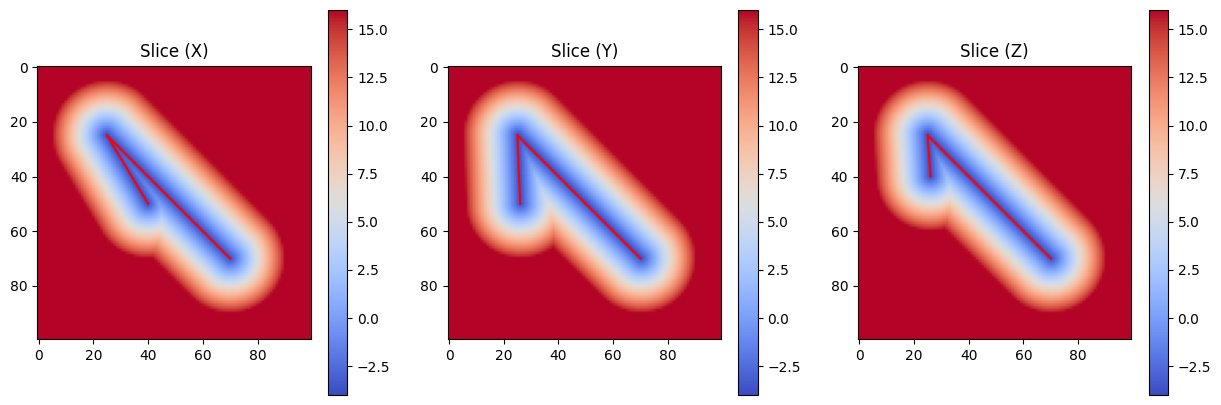

In [7]:
g = nx.Graph()
widths = th.tensor([8.0]*11,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)

g.add_node(4, pos=np.array([26,40,50]))
g.add_edge(4,5)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 100), slice(0, 100), slice(0, 100)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [9]:
pred_initial[0].shape

torch.Size([1, 100, 100, 100])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_10167/2355074557.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(torch.abs(pred_perfect)), "2D", g)


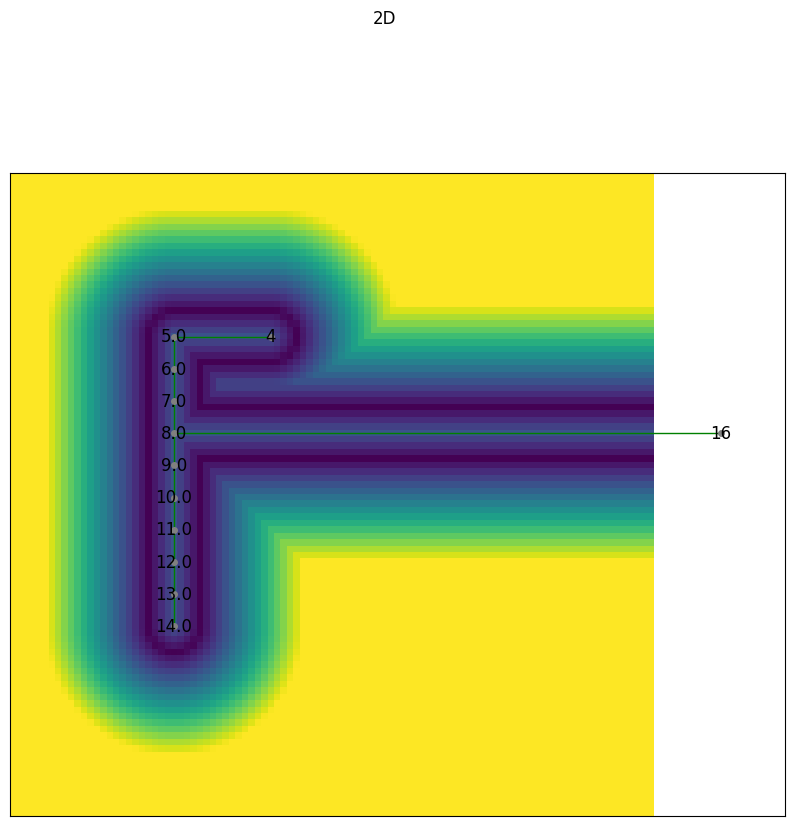

In [11]:
g = nx.Graph()
widths = th.tensor([8.0]*12,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)

g.add_node(4, pos=np.array([25, 40]))
g.add_edge(4,5)

g.add_node(16, pos=np.array([40,110]))
g.add_edge(8,16)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(torch.abs(pred_perfect)), "2D", g)

In [12]:
pred_perfect.shape

torch.Size([100, 100])